# Goal of this notebook:

Calculate vert/horiz error at passing plane.  
This plane is:
- is orthogonal to the ball's trajectory
- is parallel with gravity
- passes through the paddle



In [1]:
#%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import division

import PerformParser as pp
import pandas as pd
import numpy as np
from scipy import signal as sig
import performFun as pF
import catchE1Funs as expFun

import bokeh.plotting as bkP
import bokeh.models as bkM
from bokeh.palettes import Spectral6
import filterpy as fP


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import Quaternion as qu

bkP.output_notebook() 





BokehJS successfully loaded.

# Set parameters

In [3]:
fileTime = '2016-3-10-13-49'
#fileTime = '2015-12-9-20-52'
#fileTime = "2015-11-16-17-31"
expCfgName = "gd_pilot.cfg"
sysCfgName = "PERFORMVR.cfg"

predictiveBuffer number of frames after ball reappearance to sample predictive have position

In [4]:
predictiveBuffer = 7

# Initialize helpful dataframes

In [5]:
filePath = "../Data/exp/" + fileTime + "/"
fileName = "exp_data-" + fileTime 

### Open the data, from pickle or dict file

In [6]:
try:
    sessionDict = pd.read_pickle(filePath + fileName + '.pickle')

except:

    s1 = pp.readPerformDict(filePath + fileName + ".dict")
    expConfig = pF.createExpCfg(filePath + expCfgName)
    sysConfig = pF.createSysCfg(filePath + sysCfgName)
    sessionDict = pF.createSecondaryDataframes(s1, expConfig)
    pd.to_pickle(sessionDict, filePath + fileName + '.pickle')

In [7]:
sessionDict.keys()

['raw', 'trialInfo', 'practice', 'processed', 'calibration']

In [8]:
s1Raw = sessionDict['raw']
s1Processed = sessionDict['processed']
s1TrialInfo = sessionDict['trialInfo']

### Parse config files

In [9]:
expConfig = pF.createExpCfg(filePath + expCfgName)
sysConfig = pF.createSysCfg(filePath + sysCfgName)

Loading experiment config file: ../Data/exp/2016-3-10-13-49/gd_pilot.cfg
Experiment config file parsed correctly
Loading system config file: ../Data/exp/2016-3-10-13-49/PERFORMVR.cfg
System config file parsed correctly


### Remove calibration and practice trials

Save calibration frames in a separate dataframe

In [10]:
sessionDict.keys()

['raw', 'trialInfo', 'practice', 'processed', 'calibration']

## Calculate the XZ vector that defines the ball's initial trajectory - store in ballDirDf

In [11]:
gbTrials = s1Raw.groupby('trialNumber')

ballTrajDirXZ_XYZ = np.array(gbTrials.nth(20)['ballPos'] - gbTrials.nth(1)['ballPos'],dtype = float)

ballTrajDirXZ_XYZ = pd.DataFrame( {('ballTrajDirXZ','X'): ballTrajDirXZ_XYZ[:,0],
                                   ('ballTrajDirXZ','Y'): ballTrajDirXZ_XYZ[:,1],
                                   ('ballTrajDirXZ','Z'): ballTrajDirXZ_XYZ[:,2]},dtype=float)

ballTrajDirXZ_XYZ[('ballTrajDirXZ','Y')] = 0
ballTrajDirXZ_XYZ = ballTrajDirXZ_XYZ.apply(lambda x: np.divide(x,np.linalg.norm(x)),axis=1)

s1TrialInfo = pd.concat([s1TrialInfo,ballTrajDirXZ_XYZ],axis=1,verify_integrity=True)


### Create ballTrajLatDirXZ

In [12]:
ballTrajLatDirXZ = s1TrialInfo['ballTrajDirXZ'].apply(lambda x: np.cross(x,[0.0,1.0,0.0]),axis=1)
ballTrajLatDirXZ = ballTrajLatDirXZ.apply(lambda x: np.divide(x,np.linalg.norm(x)),axis=1)

mIndex = pd.MultiIndex.from_tuples([('ballTrajLatDirXZ','X'),('ballTrajLatDirXZ','Y'),('ballTrajLatDirXZ','Z')])
ballTrajLatDirXZ.columns = mIndex

s1TrialInfo = pd.concat([s1TrialInfo,ballTrajLatDirXZ],axis=1,verify_integrity=True)

In [13]:
trialNum = 3

gbTrialsRaw = s1Raw.groupby('trialNumber')
gbTrialsProc = s1Processed.groupby('trialNumber')

tr = 15
p1 = bkP.figure(plot_width=400, plot_height=400)

##########

ballRadius = 0.03
ball = p1.circle(0,0,color="blue", alpha=0.5)
ballGlyph = ball.glyph
ballGlyph.radius = ballRadius
ballGlyph.fill_alpha = 0.2
ballGlyph.line_color = "yellow"
ballGlyph.line_dash = [6, 3]
ballGlyph.line_width = 2

##########

ballTrajXZ = s1TrialInfo['ballTrajDirXZ'].loc[trialNum]
ballTrajX = ballTrajXZ[0]
ballTrajZ = ballTrajXZ[2]

##########

# paddleToBallVecDf = s1Raw['ballPos'] - s1Raw['paddlePos']
# p2b = paddleToBallVecDf.values[idx]
# p2bX = p2b[0]
# p2bZ = p2b[2]

##########

ballLat = s1TrialInfo['ballTrajLatDirXZ'].loc[trialNum]
bLatX = ballLat[0]
bLatZ = ballLat[2]

##########

p1.multi_line([[0,ballTrajZ],[0,bLatZ ]],[[0,ballTrajX],[0,bLatX]],line_width=4,color=["firebrick", "navy"])

p1.y_range = bkM.Range1d(-1.5, 1.5)
p1.x_range = bkM.Range1d(-1.5, 1.5)

bkP.show(p1)

# Find the time that the ball reappears

In [14]:
gbTrials = s1Raw.groupby('trialNumber')
renderOnFr_tr = pd.DataFrame(gbTrials['eventFlag'].apply( lambda x: x.index.values[pF.findFirst(x, 'ballRenderOn')]))

mIndex = pd.MultiIndex.from_tuples([('ballAppearsOnFrame','')])
renderOnFr_tr.columns =mIndex
renderOnFr_tr

s1TrialInfo = pd.concat([renderOnFr_tr,s1TrialInfo],axis=1,verify_integrity=True)

# Find the time the ball crosses the paddle plane

### Dot product of ballTrajLatDirXZ and paddleToBallDirXZ

In [15]:
gbTrials = s1Processed.groupby('trialNumber')

dotProd_idx = []
frameTime_idx = []

for trNum, tr in gbTrials:

    dotProd_idx.extend( pd.Series( np.dot( tr['paddleToBallDirXZ'], 
           np.array( s1TrialInfo['ballTrajDirXZ'].loc[ trNum ].values,dtype=float))))


dotDf = pd.DataFrame({('dot_bDir_p2b',''):dotProd_idx})
dotDf.index = s1Processed.index

s1Processed = pd.concat([dotDf,s1Processed],axis=1,verify_integrity=True)


### Plot the dot product.  They are parallel when dot product is >0 or <0

In [16]:
trialNum = 54

gbTrials = s1Processed.groupby('trialNumber')

#frametime_fr = gbTrials.get_group(trialNum).index.values,

p1 = pF.timeSeries(gbTrials.get_group(trialNum)['frameTime'].values,
                   yDataList = [gbTrials.get_group(trialNum)['dot_bDir_p2b'].values], 
                   events_fr = gbTrials.get_group(trialNum)['eventFlag'].values,
                   yLabel='dot',
                   yLims = [-1.2,1.2],
                   plotHeight=300)

#passFr = s1TrialInfo['passVertPlaneAtPaddleFr'].values[trialNum]
# print passFr
#p1.line([passFr, passFr],[-1,1],line_width=3, alpha=.7,color='LimeGreen',line_dash=[5,3])

bkP.show(p1)

### Find when the dot product crosses over zero

In [17]:
gbTrials = s1Processed.groupby('trialNumber')
arriveAtPaddleFr_tr = []

for trNum, tr in gbTrials:
    if( s1TrialInfo['ballCaughtQ'].values[trNum] == False ):
        
        passFr = pF.findFirstZeroCrossing(tr['dot_bDir_p2b'].values)       
        arriveAtPaddleFr_tr.append(tr.index.values[passFr]-1)
        
    else:
        arriveAtPaddleFr_tr.append(s1TrialInfo['ballCaughtFr'].values[trNum]-1)


s1TrialInfo['passVertPlaneAtPaddleFr'] = np.array(arriveAtPaddleFr_tr,dtype=int)

# Set the frames to sample data (predictive and passing frame)

In [18]:
passingFrames = s1TrialInfo['passVertPlaneAtPaddleFr']

predictiveFrames = s1TrialInfo['ballAppearsOnFrame'].values + predictiveBuffer

### Lets look at the predictive frame

In [19]:
trialNum = 100

gbTrials = s1Raw.groupby('trialNumber')

p1 = pF.timeSeries(gbTrials.get_group(trialNum)['frameTime'].values,
                   yDataList = [gbTrials.get_group(trialNum)['ballPos']['Y'].values], 
                   events_fr = gbTrials.get_group(trialNum)['eventFlag'].values,
                   yLabel='dot',
                   yLims = [-1.2,20],
                   plotHeight=300)

passT = s1Raw['frameTime'].values[predictiveFrames[trialNum]]
p1.line([passT,passT],[-1,20],line_width=3, alpha=.7,color='LimeGreen',line_dash=[5,3])

bkP.show(p1)

# Vertical error

Calculate error between paddle position on predFrame and ball position on passing frame

In [20]:
vertError_tr = s1Raw['ballPos']['Y'].values[predictiveFrames] - s1Raw['paddlePos']['Y'].values[passingFrames]
s1TrialInfo[('predCatchErrAtVertPlane','Y')] = vertError_tr

# Horizontal error

In [21]:
p2bDf = pd.DataFrame(s1Raw['ballPos'].values[predictiveFrames] - s1Raw['paddlePos'].values[passingFrames])
ballTrajLat = s1TrialInfo['ballTrajLatDirXZ']

horizError_tr = []

for trNum in range(len(s1TrialInfo)):
    
    horizError_tr.extend( pd.Series( np.dot( p2bDf.loc[trNum],ballTrajLat.loc[trNum]),dtype=float))


s1TrialInfo[('predCatchErrAtVertPlane','X')] =  horizError_tr

# 2D error

In [22]:
XX = np.power(np.array(s1TrialInfo['predCatchErrAtVertPlane']['X'],dtype=float),2)
YY = np.power(np.array(s1TrialInfo['predCatchErrAtVertPlane']['Y'],dtype=float),2)

s1TrialInfo[('predCatchErrAtVertPlane','2D')] =  np.sqrt(np.sum([XX, YY],axis=0))


## Calc flight time, or "timeToPaddle"

In [23]:
passOrCatchFr = s1TrialInfo['passVertPlaneAtPaddleFr'].values
s1TrialInfo['timeToPaddle'] = s1Raw['frameTime'][passOrCatchFr].values - s1Raw['frameTime'][s1TrialInfo['firstFrame'].values].values

## Identify "miss" trials, in which the ball was not caught


In [24]:
caughtGroups = s1TrialInfo.groupby('ballCaughtQ')
misssedTrials = np.array(caughtGroups.get_group(False).index,dtype=int)
caughtTrials = np.array(caughtGroups.get_group(True).index,dtype=int)

### TTC

In [25]:
s1TrialInfo['initTTC'] = s1TrialInfo['preBlankDur'] + s1TrialInfo['blankDur'] + s1TrialInfo['postBlankDur']

# Plot error

In [26]:
#bkP.output_file('catchingErrorVertPlane.html')

In [27]:
paddleRadius = 0.15
ballRadius = 0.045

TOOLS = "pan,wheel_zoom,hover,save"

p = bkP.figure(plot_width=400, plot_height=400,tools=TOOLS)

##############################
## Missed balls


missedSource = bkM.ColumnDataSource(
    data=dict(
        trialNum = [str(x) for x in s1TrialInfo.index[misssedTrials]],
        #minErr = [str(x) for x in s1TrialInfo.index], # a placeholder        
        preBlankDur = [str(x) for x in s1TrialInfo['preBlankDur'].values[misssedTrials]],
        blankDur = [str(x) for x in s1TrialInfo['blankDur'].values[misssedTrials]],
        postBlankDur = [str(x) for x in s1TrialInfo['postBlankDur'].values[misssedTrials]],
        timeToPaddle = [str("%.2f" % x) for x in s1TrialInfo['timeToPaddle'].values[misssedTrials]],

    )
)

missedBalls  = p.circle(s1TrialInfo['predCatchErrAtVertPlane']['X'].values[misssedTrials],
                  s1TrialInfo['predCatchErrAtVertPlane']['Y'].values[misssedTrials], color="red",source=missedSource)

missedBallGlyph = missedBalls.glyph
missedBallGlyph.radius = ballRadius
missedBallGlyph.fill_alpha = 0.2
missedBallGlyph.line_color = "red"
missedBallGlyph.line_alpha = 0.2
missedBallGlyph.line_width = 2


##############################
## Caught balls


caughtSource = bkM.ColumnDataSource(
    data=dict(
        trialNum = [str(x) for x in s1TrialInfo.index[caughtTrials]],
        #minErr = [str(x) for x in s1TrialInfo.index], # a placeholder        
        preBlankDur = [str(x) for x in s1TrialInfo['preBlankDur'].values[caughtTrials]],
        blankDur = [str(x) for x in s1TrialInfo['blankDur'].values[caughtTrials]],
        postBlankDur = [str(x) for x in s1TrialInfo['postBlankDur'].values[caughtTrials]],
        timeToPaddle = [str( "%.2f" % x) for x in s1TrialInfo['timeToPaddle'].values[caughtTrials]],
    )
)

caughtBalls  = p.circle(s1TrialInfo['predCatchErrAtVertPlane']['X'].values[caughtTrials],
                  s1TrialInfo['predCatchErrAtVertPlane']['Y'].values[caughtTrials], color="green",
                        source=caughtSource)

caughtBallGlyph = caughtBalls.glyph
caughtBallGlyph.radius = ballRadius
caughtBallGlyph.fill_alpha = 0.2
caughtBallGlyph.line_alpha = 0.2
caughtBallGlyph.line_color = "green"
caughtBallGlyph.line_width = 2


##############################
## Paddle

paddle = p.circle(0,0, color="yellow", alpha=0.5)
paddleGlyph = paddle.glyph
paddleGlyph.radius = paddleRadius
paddleGlyph.fill_alpha = 0.2
paddleGlyph.line_color = "yellow"
paddleGlyph.line_dash = [6, 3]
paddleGlyph.line_width = 2
paddleGlyph.line_color = "firebrick"

p.y_range = bkM.Range1d(-.75,.75)
p.x_range = bkM.Range1d(-.75,.75)

p.axis.axis_label = 'meters'

from collections import OrderedDict

hover = p.select(dict(type=bkM.HoverTool))
hover.tooltips = OrderedDict([
    ("trialNum", "@trialNum"),
    ("preBlankDur", "@preBlankDur"),
    ("blankDur", "@blankDur"),
    ("postBlankDur", "@postBlankDur"),
    ("timeToPaddle", "@timeToPaddle"),
])

# show the results
bkP.show(p)

### Is this variation due to changes in hand position, or differences in ball trajectory?

In [28]:
predHandPos_tr_XYZ = s1Raw['paddlePos'].loc[predictiveFrames].values
predHandPosDf = pd.DataFrame(predHandPos_tr_XYZ)

mIndex = pd.MultiIndex.from_tuples([('predictiveHandPosition','X'),('predictiveHandPosition','Y'),('predictiveHandPosition','Z')])
predHandPosDf.columns = mIndex

s1TrialInfo = pd.concat([s1TrialInfo,predHandPosDf],axis=1,verify_integrity=True)

/Users/kamranbinaee/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


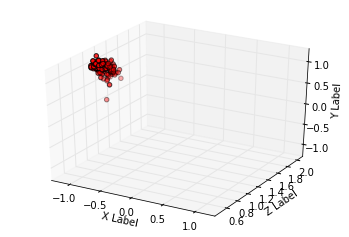

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(predHandPos_tr_XYZ[:,0], predHandPos_tr_XYZ[:,2],predHandPos_tr_XYZ[:,1], c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
ax.set_zlabel('Y Label')

plt.axis('equal')
span = 2.5

ax.set_xlim3d([-span/2, span/2])
ax.set_ylim3d([0, span])
ax.set_zlim3d([-span/2, span/2])

plt.show()


### Gather final ball positions

In [30]:
#predHandPosDf

finalBallPos_tr_XYZ = s1Raw['ballPos'].loc[passingFrames].values
finalBallPosDf = pd.DataFrame(finalBallPos_tr_XYZ)

mIndex = pd.MultiIndex.from_tuples([('finalBallPos','X'),('finalBallPos','Y'),('finalBallPos','Z')])
finalBallPosDf.columns = mIndex

s1TrialInfo = pd.concat([s1TrialInfo,finalBallPosDf],axis=1,verify_integrity=True)


In [31]:
p = bkP.figure(width=500, height=500)

p.scatter(s1TrialInfo['predictiveHandPosition']['Y'], s1TrialInfo['finalBallPos']['Y'], color='orange',line_width=2)

p.xaxis.axis_label = 'hand position @ pred'
p.yaxis.axis_label = 'final ball position'

p.x_range = bkM.Range1d(1.2,2.8)
p.y_range = bkM.Range1d(1.2,2.8)

bkP.show(p)


### Lets do this again, but only for successful trials

In [32]:
def errorbar(fig, x, y, xerr=None, yerr=None, color='orange', point_kwargs={}, error_kwargs={}):

    fig.circle(x, y, color=color, **point_kwargs)


    if xerr is not None:
      x_err_x = []
      x_err_y = []
      for px, py, err in zip(x, y, xerr):
          x_err_x.append((px - err, px + err))
          x_err_y.append((py, py))
      fig.multi_line(x_err_x, x_err_y, color=color, **error_kwargs)

    if yerr is not None:
      y_err_x = []
      y_err_y = []
      for px, py, err in zip(x, y, yerr):
          y_err_x.append((px, px))
          y_err_y.append((py - err, py + err))
      fig.multi_line(y_err_x, y_err_y, color=color, **error_kwargs)

In [33]:
def plotMainEffect(dF,xVar,yVar, plotTitle = False):

    groupedBy =  dF.groupby(xVar)

    pre_mean = []
    pre_std = []

    for gNum, gr in groupedBy:
        pre_mean.append(np.mean(gr[yVar].values))
        pre_std.append(np.std(gr[yVar].values))

    xs = np.unique(dF[xVar].round(decimals =2))
    yerr = pre_std
    ys = pre_mean

    # plot the pointsa
    p = bkP.figure(width=800, height=400)
    p.line(xs, ys, color='orange',line_width=2)
    errorbar(p,xs,ys, yerr=yerr,point_kwargs={'size': 10}, error_kwargs={'line_width': 3})

    p.xaxis.axis_label = xVar
    p.yaxis.axis_label = ''.join(yVar)

    if( plotTitle ):
        p.title = plotTitle
        
    return p

In [34]:
xVar = 'postBlankDur'
yVar = 'predictiveHandPosition','Y'

p = plotMainEffect(s1TrialInfo,xVar,yVar,'Predictive Hand Y by Post')
p.y_range = bkM.Range1d(-1,3)
bkP.show(p)

In [35]:
xVar = 'preBlankDur'
yVar = 'predictiveHandPosition','Y'

p = plotMainEffect(s1TrialInfo,xVar,yVar)
p.y_range = bkM.Range1d(-1,3)
bkP.show(p)

## Main effect of postblank Dur

In [36]:
xVar = 'postBlankDur'
yVar = 'predCatchErrAtVertPlane','2D'

p = plotMainEffect(s1TrialInfo,xVar,yVar)
p.y_range = bkM.Range1d(-1,3)
bkP.show(p)

In [37]:
xVar = 'postBlankDur'
yVar = 'predCatchErrAtVertPlane','X'

p = plotMainEffect(s1TrialInfo,xVar,yVar)
p.y_range = bkM.Range1d(-1,3)
bkP.show(p)

In [38]:
xVar = 'postBlankDur'
yVar = 'predCatchErrAtVertPlane','Y'

p = plotMainEffect(s1TrialInfo,xVar,yVar)
p.y_range = bkM.Range1d(-1,3)
bkP.show(p)

## Main effect of preblank duration

In [39]:
xVar = 'preBlankDur'
yVar = 'predCatchErrAtVertPlane','2D'

p = plotMainEffect(s1TrialInfo,xVar,yVar)
p.y_range = bkM.Range1d(-1,3)
bkP.show(p)

In [40]:
xVar = 'preBlankDur'
yVar = 'predCatchErrAtVertPlane','X'

p = plotMainEffect(s1TrialInfo,xVar,yVar)
p.y_range = bkM.Range1d(-1,3)
bkP.show(p)

In [41]:
xVar = 'preBlankDur'
yVar = 'predCatchErrAtVertPlane','Y'

p = plotMainEffect(s1TrialInfo,xVar,yVar)
p.y_range = bkM.Range1d(-1,3)
bkP.show(p)

# Lets look at the interactions

In [42]:
def plotInteraction(dF, xVar,yVar, lineVar):
    
    lineNames = np.array(np.unique(dF[lineVar].round(decimals =2)),dtype=np.str)
    groupedByXVar =  dF.groupby([xVar,lineVar])
    
    numX = dF.groupby(xVar).ngroups
    numLines = dF.groupby(lineVar).ngroups
    
    if( len(np.unique([g[yVar].count() for gNum, g in groupedByXVar])) > 1):
        print 'This function not yet able to handle groups that differ in num repetitions'
        return
    else:
        numReps = np.unique([g[yVar].count() for gNum, g in groupedByXVar])[0]
    
    mean_cond = []
    std_cond  = []
    values_cond = []
    
    for gNum, gr in groupedByXVar:
        values_cond.append(gr[yVar].values)
        mean_cond.append(np.mean(gr[yVar].values))
        std_cond.append(np.std(gr[yVar].values))

    
    mean_x_lines = np.reshape(mean_cond,[numX,numLines])
    std_x_lines = np.reshape(std_cond,[numX,numLines])
    val_lines_x_reps = np.reshape(values_cond,[numLines,numX,numReps])

    xs_l_x = [np.unique(dF[xVar].round(decimals=2))]*numLines # it's numlines, right?
    ys_l_x = [np.array(v,dtype=np.float) for v in mean_x_lines]
    yerr_l_x = [np.array(v,dtype=np.float) for v in std_x_lines]
    
    p = bkP.figure(width=800, height=400)

    off_lIdx = [-.01, 0, .01]
    clist_lIdx = ['blue','orange','green']

    for lIdx in range(numLines):
        
        p.line( xs_l_x[lIdx]+off_lIdx[lIdx], ys_l_x[lIdx] ,line_width=3,color=clist_lIdx[lIdx],legend = 'Post ' + lineNames[lIdx])
        
        errorbar(p,xs_l_x[lIdx]+off_lIdx[lIdx],ys_l_x[lIdx], yerr=yerr_l_x,color=clist_lIdx[lIdx], 
                 point_kwargs={'line_width':3,'size': 10}, 
                 error_kwargs={'line_width': 3})
        
    for xIdx in range(numX):
        for lIdx in range(numLines):
            
            p.scatter(np.repeat(xs_l_x[lIdx][xIdx]+off_lIdx[lIdx],numReps), val_lines_x_reps[lIdx,xIdx,:],
                     color=np.repeat(clist_lIdx[lIdx],numReps))



    
    p.xaxis.axis_label = xVar
    p.yaxis.axis_label = ''.join(yVar)
    
    p.legend.orientation = "top_left"
    return p

In [43]:
yVar = 'predictiveHandPosition','Y'
xVar = 'preBlankDur'
lineVar = 'postBlankDur'

p = plotInteraction(s1TrialInfo,xVar,yVar, lineVar)
p.y_range = bkM.Range1d(-1,3)
bkP.show(p)

/Users/kamranbinaee/anaconda/lib/python2.7/site-packages/bokeh/core/properties.py:714: BokehDeprecationWarning: bokeh.models.annotations.orientation was deprecated in Bokeh 0.11; please use Legend.location instead
  super(HasProps, self).__setattr__(name, value)


In [44]:
yVar = 'predCatchErrAtVertPlane','2D'
xVar = 'preBlankDur'
lineVar = 'postBlankDur'

p = plotInteraction(s1TrialInfo,xVar,yVar, lineVar)

yLims = p.y_range
xLims = p.x_range

#lineSize = 0.1
#xAxis = bkM.BoxAnnotation(plot=p, bottom = -lineSize/2, top=lineSize/2, fill_alpha=0.7, fill_color='black', level='underlay')
#yAxis = bkM.BoxAnnotation(plot=p, left = -lineSize/2, right=lineSize/2, fill_alpha=0.7, fill_color='black', level='underlay')
#p.renderers.extend([xAxis])
#p.renderers.extend([yAxis])

p.y_range = bkM.Range1d(-1,3)
bkP.show(p)

/Users/kamranbinaee/anaconda/lib/python2.7/site-packages/bokeh/core/properties.py:714: BokehDeprecationWarning: bokeh.models.annotations.orientation was deprecated in Bokeh 0.11; please use Legend.location instead
  super(HasProps, self).__setattr__(name, value)


### X error

In [45]:
yVar = 'predCatchErrAtVertPlane','X'
xVar = 'preBlankDur'
lineVar = 'postBlankDur'

p = plotInteraction(s1TrialInfo,xVar,yVar, lineVar)
p.y_range = bkM.Range1d(-0.5,0.5)
bkP.show(p)

/Users/kamranbinaee/anaconda/lib/python2.7/site-packages/bokeh/core/properties.py:714: BokehDeprecationWarning: bokeh.models.annotations.orientation was deprecated in Bokeh 0.11; please use Legend.location instead
  super(HasProps, self).__setattr__(name, value)


### Y Error

In [46]:
yVar = 'predCatchErrAtVertPlane','Y'
xVar = 'preBlankDur'
lineVar = 'postBlankDur'

p = plotInteraction(s1TrialInfo,xVar,yVar, lineVar)
p.y_range = bkM.Range1d(-1,3)
bkP.show(p)

/Users/kamranbinaee/anaconda/lib/python2.7/site-packages/bokeh/core/properties.py:714: BokehDeprecationWarning: bokeh.models.annotations.orientation was deprecated in Bokeh 0.11; please use Legend.location instead
  super(HasProps, self).__setattr__(name, value)


# Pre by ttc

In [47]:
def plotInteractionB(dF, xVar,yVar, lineVar):
    
    lineNames = np.array(np.unique(dF[lineVar].round(decimals =2)),dtype=np.str)
    groupedByXVar =  dF.groupby([xVar,lineVar])
    
    numX = dF.groupby(xVar).ngroups
    numLines = dF.groupby(lineVar).ngroups
    
    if( len(np.unique([g[yVar].count() for gNum, g in groupedByXVar])) > 1):
        print 'This function not yet able to handle groups that differ in num repetitions'
        return
    else:
        numReps = np.unique([g[yVar].count() for gNum, g in groupedByXVar])[0]
    
    mean_cond = []
    std_cond  = []
    values_cond = []
    
    for gNum, gr in groupedByXVar:
        values_cond.append(gr[yVar].values)
        mean_cond.append(np.mean(gr[yVar].values))
        std_cond.append(np.std(gr[yVar].values))

    print np.shape(mean_cond)
    
    mean_x_lines = np.reshape(mean_cond,[numX,numLines])
    std_x_lines = np.reshape(std_cond,[numX,numLines])
    val_lines_x_reps = np.reshape(values_cond,[numLines,numX,numReps])

    print np.shape(mean_x_lines)
    
#     xs_l_x = [np.unique(dF[xVar].round(decimals=2))]*numLines # it's numlines, right?
#     ys_l_x = [np.array(v,dtype=np.float) for v in mean_x_lines]
#     yerr_l_x = [np.array(v,dtype=np.float) for v in std_x_lines]
    
#     p = bkP.figure(width=800, height=400)

#     off_lIdx = [-.01, 0, .01]
#     clist_lIdx = ['blue','orange','green']

#     for lIdx in range(numLines):
        
#         p.line( xs_l_x[lIdx]+off_lIdx[lIdx], ys_l_x[lIdx] ,line_width=3,color=clist_lIdx[lIdx],legend = 'Post ' + lineNames[lIdx])
        
#         errorbar(p,xs_l_x[lIdx]+off_lIdx[lIdx],ys_l_x[lIdx], yerr=yerr_l_x,color=clist_lIdx[lIdx], 
#                  point_kwargs={'line_width':3,'size': 10}, 
#                  error_kwargs={'line_width': 3})
        
#     for xIdx in range(numX):
#         for lIdx in range(numLines):
            
#             p.scatter(np.repeat(xs_l_x[lIdx][xIdx]+off_lIdx[lIdx],numReps), val_lines_x_reps[lIdx,xIdx,:],
#                      color=np.repeat(clist_lIdx[lIdx],numReps))


#     p.xaxis.axis_label = xVar
#     p.yaxis.axis_label = ''.join(yVar)

    #return p

In [48]:
yVar = 'predCatchErrAtVertPlane','Y'
xVar = 'initTTC'
lineVar = 'preBlankDur'

p = plotInteractionB(s1TrialInfo,xVar,yVar, lineVar)
p.y_range = bkM.Range1d(0,3)
bkP.show(p)

(9,)


ValueError: total size of new array must be unchanged

### Post by ttc

In [ ]:
yVar = 'predCatchErrAtVertPlane','Y'
xVar = 'initTTC'
lineVar = 'postBlankDur'

p = plotInteraction(xVar,yVar, lineVar)
p.y_range = bkM.Range1d(0,3)
bkP.show(p)

# Plot by init time to contact

In [ ]:

xVar = 'initTTC'
yVar = 'predCatchErrAtVertPlane','2D'

pre_mean = []
pre_std = []

groupedByPre =  s1TrialInfo.groupby(xVar)

for gNum, gr in groupedByPre:
    pre_mean.append(np.mean(gr[yVar].values))
    pre_std.append(np.std(gr[yVar].values))

xs = np.unique(s1TrialInfo['postBlankDur'].round(decimals =2))
yerr = pre_std
ys = pre_mean

#output_file('bokeh_errorbars.html')

# plot the points
p = bkP.figure(width=800, height=400)
p.line(xs, ys, color='green',line_width=2)
errorbar(p,xs,ys, yerr=yerr,point_kwargs={'size': 10}, error_kwargs={'line_width': 3})

p.xaxis.axis_label = xVar
p.yaxis.axis_label = ''.join(yVar)
p.y_range = bkM.Range1d(0,3)

bkP.show(p)

In [ ]:

xVar = 'initTTC'
yVar = 'predCatchErrAtVertPlane','X'

pre_mean = []
pre_std = []

groupedByPre =  s1TrialInfo.groupby(xVar)

for gNum, gr in groupedByPre:
    pre_mean.append(np.mean(gr[yVar].values))
    pre_std.append(np.std(gr[yVar].values))

xs = np.unique(s1TrialInfo['postBlankDur'].round(decimals =2))
yerr = pre_std
ys = pre_mean

#output_file('bokeh_errorbars.html')

# plot the points
p = bkP.figure(width=800, height=400)
p.line(xs, ys, color='green',line_width=2)
errorbar(p,xs,ys, yerr=yerr,point_kwargs={'size': 10}, error_kwargs={'line_width': 3})

p.xaxis.axis_label = xVar
p.yaxis.axis_label = ''.join(yVar)
p.y_range = bkM.Range1d(0,3)

bkP.show(p)

In [ ]:

xVar = 'initTTC'
yVar = 'predCatchErrAtVertPlane','Y'

pre_mean = []
pre_std = []

groupedByPre =  s1TrialInfo.groupby(xVar)

for gNum, gr in groupedByPre:
    pre_mean.append(np.mean(gr[yVar].values))
    pre_std.append(np.std(gr[yVar].values))

xs = np.unique(s1TrialInfo['postBlankDur'].round(decimals =2))
yerr = pre_std
ys = pre_mean

#output_file('bokeh_errorbars.html')

# plot the points
p = bkP.figure(width=800, height=400)
p.line(xs, ys, color='green',line_width=2)
errorbar(p,xs,ys, yerr=yerr,point_kwargs={'size': 10}, error_kwargs={'line_width': 3})

p.xaxis.axis_label = xVar
p.yaxis.axis_label = ''.join(yVar)
p.y_range = bkM.Range1d(0,3)

bkP.show(p)